<a href="https://colab.research.google.com/github/MANOJ-S-NEGI/TENSORFLOW/blob/main/CNN_Transfer_Learning(Resnet_V_S_EfficeintnetB0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import datetime
import numpy as np
import pandas as pd
import random
import pathlib
import datetime
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:

## importing the functions:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2022-02-10 07:18:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2022-02-10 07:18:22 (175 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
## walking through the directory:
# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
test_dir="10_food_classes_10_percent/test/"
train_dir="10_food_classes_10_percent/train/"

In [ ]:
data_dir= pathlib.Path(train_dir)
class_label=np.array(sorted([item.name for item in data_dir.glob('*')]))
data_dir,class_label


(PosixPath('10_food_classes_10_percent/train'),
 array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
        'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
       dtype='<U14'))

In [ ]:
import random
def file(target_file):
    folder_label= random.choice(class_label)
    target_dir= target_file + folder_label
    random_image=random.choice(os.listdir(target_dir))
    target_img= target_dir+'/'+random_image

    img=mpimg.imread(target_img)
    
    plt.imshow(img)
    plt.title(folder_label)
    plt.axis(False)

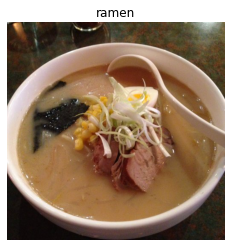

In [ ]:
file(train_dir)

```
Transfer learning :

Now we'll get the feature vector URLs of two common computer vision architectures, EfficientNetB0 (2019) and ResNetV250 (2016) from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.

🔑 Note: Comparing different model architecture performance on the same data is a very common practice. The simple reason is because you want to know which model performs best for your problem.

Update: As of 14 August 2021, EfficientNet V2 pretrained models are available on TensorFlow Hub. The original code in this notebook uses EfficientNet V1, it has been left unchanged. In my experiments with this dataset, V1 outperforms V2.
```

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen= ImageDataGenerator(rescale=1/255.)

train_data=train_datagen.flow_from_directory(train_dir,
                                             batch_size=32,
                                            target_size=(224,224),
                                             class_mode='categorical')

test_data=test_datagen.flow_from_directory(test_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
def callbacks(dir_path,name):
    dir= dir_path +'/'+ name +'/'+ datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tb=tf.keras.callbacks.TensorBoard(dir) 
    return tb
tensor_callback= callbacks("/content/10_food_classes_10_percent","effBO/resnet50-101_food_10_per")

In [ ]:
#creating the model:
model=tf.keras.Sequential([
                                 hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5",
                                                        trainable=False,
                                                                input_shape=(224,224,3)),
                                 tf.keras.layers.Dense(10,activation='sigmoid')
])

model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

history=model.fit( train_data,
             epochs=5,
                 steps_per_epoch=len(train_data),
                     validation_data=test_data,
                            validation_steps=len(test_data)
                            ,callbacks=tensor_callback)
          

Epoch 1/5
24/24 [==============================] - 27s 972ms/step - loss: 2.6358 - accuracy: 0.3067 - val_loss: 1.2320 - val_accuracy: 0.5832
Epoch 2/5
24/24 [==============================] - 22s 925ms/step - loss: 0.9997 - accuracy: 0.6973 - val_loss: 0.9057 - val_accuracy: 0.7024
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.7159 - accuracy: 0.7587 - val_loss: 0.8279 - val_accuracy: 0.7280
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.5557 - accuracy: 0.8213 - val_loss: 0.7717 - val_accuracy: 0.7416
Epoch 5/5
24/24 [==============================] - 23s 977ms/step - loss: 0.4560 - accuracy: 0.8667 - val_loss: 0.7729 - val_accuracy: 0.7500


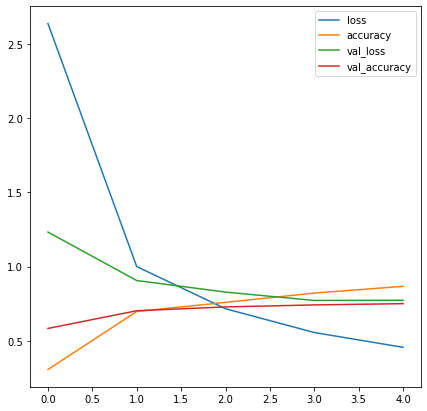

In [ ]:
pd.DataFrame(history.history).plot(figsize=(7,7))

In [ ]:
#creating the model:
model_B=tf.keras.Sequential([
                                 hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                                                        trainable=False,
                                                                input_shape=(224,224,3)),
                                 tf.keras.layers.Dense(10,activation='sigmoid')
])

model_B.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

history_B=model_B.fit( train_data,
             epochs=5,
                 steps_per_epoch=len(train_data),
                     validation_data=test_data,
                            validation_steps=len(test_data)
                            ,callbacks=tensor_callback)
          

Epoch 1/5
24/24 [==============================] - 37s 973ms/step - loss: 1.8149 - accuracy: 0.4640 - val_loss: 1.2772 - val_accuracy: 0.7216
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.0435 - accuracy: 0.7760 - val_loss: 0.8588 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 20s 869ms/step - loss: 0.7499 - accuracy: 0.8333 - val_loss: 0.6947 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 23s 984ms/step - loss: 0.6037 - accuracy: 0.8667 - val_loss: 0.6082 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 20s 838ms/step - loss: 0.5113 - accuracy: 0.8960 - val_loss: 0.5565 - val_accuracy: 0.8616


In [ ]:
def plot_curve(): 
    plt.figure(figsize=(7,7))
    H1_acc=history.history['accuracy']
    HB_acc=history_B.history['accuracy']
    plt.plot(H1_acc,label='Training Acc (resnet_50)')
    plt.plot(HB_acc,label='Training Acc (Efficient_B0')
    plt.title("Accuracy Graph for model resnet_50 V/s Efficient_BO")
    plt.legend()

    plt.figure(figsize=(7,7))
    H1_val_acc=history.history['val_accuracy']
    HB_val_acc=history_B.history['val_accuracy']
    plt.plot(H1_val_acc,label='Validation Acc (resnet_50)')
    plt.plot(HB_val_acc,label='Validation Acc (Efficient_B0')
    plt.title("Validation_Accuracy Graph for model resnet_50 V/s Efficient_BO")
    plt.legend()

    plt.figure(figsize=(7,7))
    H1_loss=history.history['loss']
    HB_loss=history_B.history['loss']
    plt.plot(H1_loss,label='Training loss (resnet_50)')
    plt.plot(HB_loss,label='Training loss (Efficient_B0')
    plt.title("Loss Graph for model resnet_50 V/s Efficient_BO")
    plt.legend()
    
    plt.figure(figsize=(7,7))
    H1_val_loss=history.history['val_loss']
    HB_val_loss=history_B.history['val_loss']
    plt.plot(H1_val_loss,label='Validation loss (resnet_50)')
    plt.plot(HB_val_loss,label='Validation loss (Efficient_B0')
    plt.title("Val_Loss Graph for model resnet_50 V/s Efficient_BO")
    plt.legend()

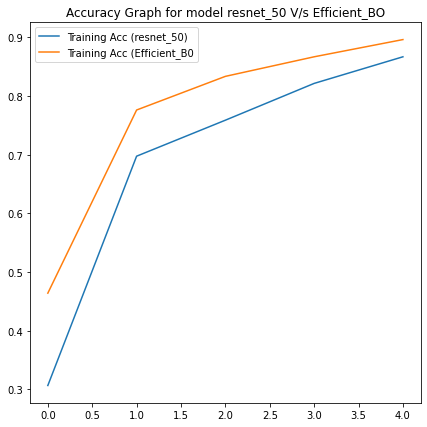

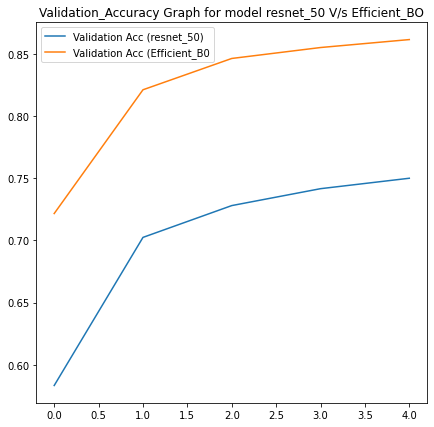

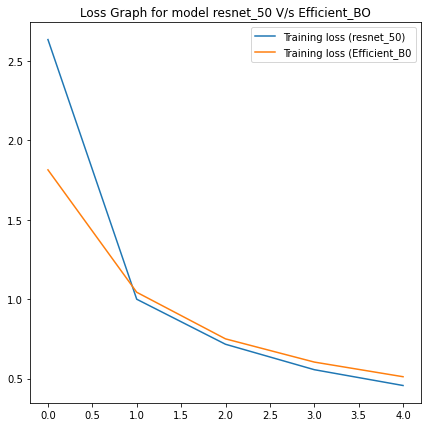

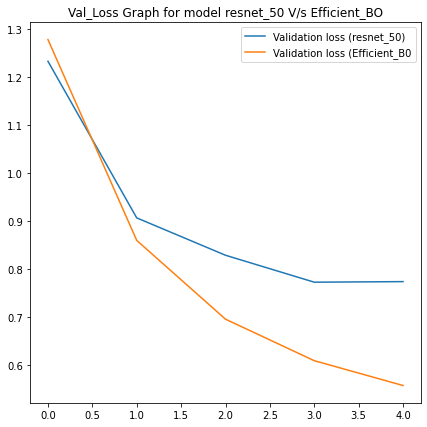

In [ ]:
plot_curve();

```
EfficientB0 :Epoch 5/5
24/24 [==============================] - 20s 838ms/step - loss: 0.5113 - accuracy: 0.8960 - val_loss: 0.5565 - val_accuracy: 0.8616

Out performs 

resnet_50 :Epoch 5/5
24/24 [==============================] - 23s 977ms/step - loss: 0.4560 - accuracy: 0.8667 - val_loss: 0.7729 - val_accuracy: 0.7500

Also dipicted through plot Curves.
```

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot